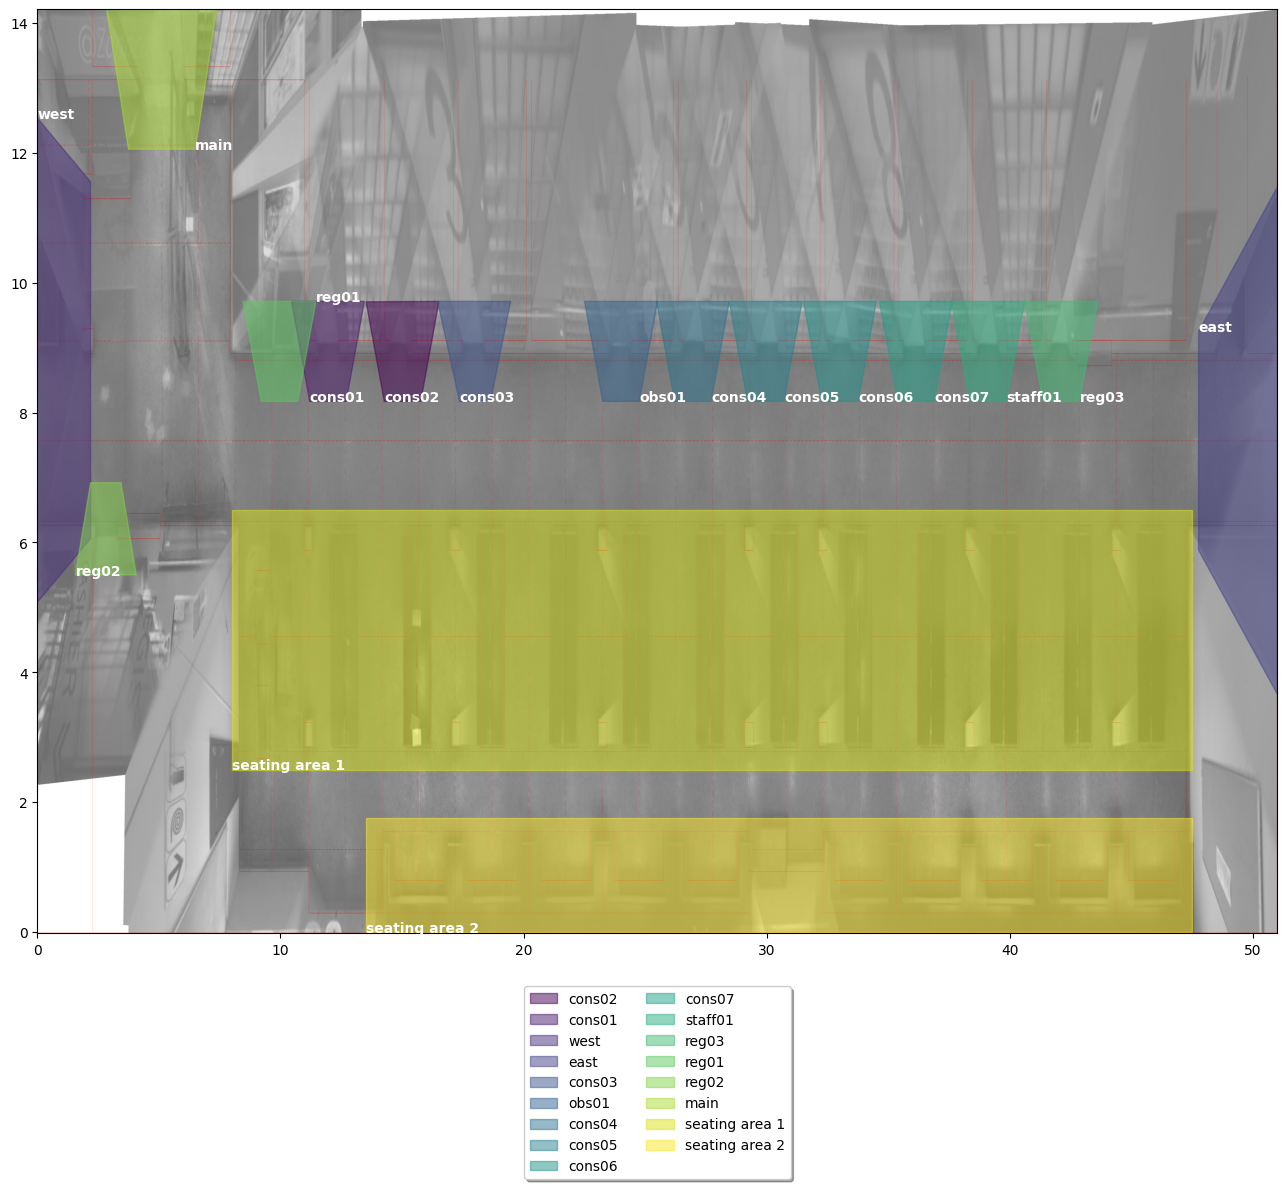

In [297]:
import os
import pandas as pd
import json
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.dates import DateFormatter
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap

def plot_with_background(ax, alpha = .5):
    """
    Creates a plot with a background image.

    Parameters:
    - ax: The matplotlib axis object containing the plot.
    """
    # Path to your image file
    image_path = '../data-raw/background/image3195.png'
    
    # Coordinates for the image placement
    image_extent = (0, 51, -0.02, 14.214)

    # Load the background image
    img = mpimg.imread(image_path)
    
    # If an extent is provided, use it to correctly scale and position the image
    if image_extent:
        ax.imshow(img, aspect='auto', extent=image_extent, zorder=-1, alpha = alpha)
    else:
        ax.imshow(img, aspect='auto', zorder=-1, alpha = alpha)
    
    return ax



# Load the JSON data
with open('../data-raw/background/config.json') as f:
    data = json.load(f)

# Navigate to the singlesensors within bern-multi01
geometries = data['multisensors']['bern-multi01']['geometries']

# Filter geometries for zones containing "entry" in their name
geometries = [g for g in geometries if g['type'] == 'ZONE' and 'entry' in g['name'].lower()]

# Preprocess geometries to remove "act_" prefix from names
for geometry in geometries:
    if geometry['name'].startswith('act_entry_'):
        geometry['name'] = geometry['name'][10:]  # Remove the first 4 characters 'act_'

# Define the coordinates for the rectangle
seating_area_coords = [[8, 2.5], [47.5, 2.5], [47.5, 6.5], [8, 6.5]]

# Create the new geometry dictionary
seating_area_geometry = {
    'geometry': seating_area_coords,
    'type': 'ZONE',
    'name': 'seating area 1'
}

# Append the new geometry to the geometries list
geometries.append(seating_area_geometry)

# Define the coordinates for the new rectangle
seating_area_2_coords = [[13.5, 0], [47.5, 0], [47.5, 1.75], [13.5, 1.75]]

# Create the new geometry dictionary for the second seating area
seating_area_2_geometry = {
    'geometry': seating_area_2_coords,
    'type': 'ZONE',
    'name': 'seating area 2'
}

# Append the new geometry to the geometries list
geometries.append(seating_area_2_geometry)

def plot_with_background_geom(ax, geometries):
    """
    Plots the geometries on a background image.

    Parameters:
    - ax: The matplotlib axes object where the plot will be drawn.
    - geometries: A list of geometry dictionaries, each containing 'geometry', 'type', and 'name' keys.

    Returns:
    - The modified axes object with the geometries plotted.
    """
    # Plot the background image first
    ax = plot_with_background(ax, 1)

    # Color cycle for different polygons
    colors = plt.cm.viridis(np.linspace(0, 1, len(geometries)))

    for i, geometry in enumerate(geometries):
        # Extract the coordinates directly from the 'geometry' key
        coords = geometry['geometry']
        
        # Check if the geometry is a LINE or a ZONE to decide on closure
        if geometry['type'] == 'ZONE':
            closed = True
        else:  # For 'LINE', do not close the polygon
            closed = False
        
        # Create a polygon or line from the coordinates
        polygon = Polygon(xy=coords, closed=closed, color=colors[i], label=geometry['name'], alpha=0.5)
        
        # Add the polygon or line to the plot
        ax.add_patch(polygon)
        
        # Label the polygon or line with its name
        # Use the first vertex for the label position
        ax.annotate(geometry['name'], xy=coords[0], color='white', weight='bold')

    # Adjust the legend to be below the plot
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)

    return ax

fig, ax = plt.subplots(figsize=(16, 12))
ax = plot_with_background_geom(ax, geometries)
plt.show()

# Data

In [291]:
# unlinked tracks
test_unlinked = pd.read_csv('../data-clean/tracking/unlinked-event-20-06-2024.csv')
n_unlink = test_unlinked['track_id'].nunique()

test_linked = pd.read_csv('../data-clean/tracking/linked-event-20-06-2024.csv')
n_link = test_linked['track_id'].nunique()

print(f'Number of unlinked tracks: {n_unlink}')
print(f'Number of linked tracks: {n_link}')

Number of unlinked tracks: 11205
Number of linked tracks: 8887


# Checks

## Duration distribution

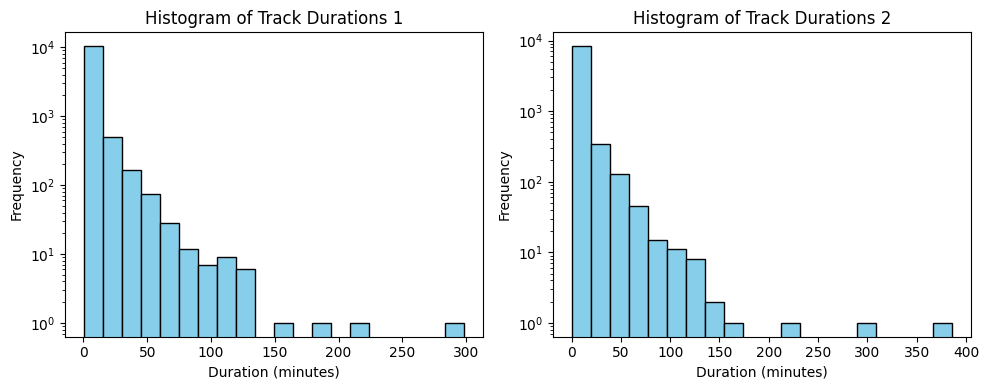

In [292]:
def compute_track_duration(df):
    """
    Computes the duration of each track.
    
    Parameters:
    - df: A pandas DataFrame with 'track_id' and 'time' columns.
    
    Returns:
    - A pandas DataFrame with 'track_id' and 'duration' for each track.
    """
    # Calculate the duration by subtracting the first time from the last time for each track
    duration_df = df.groupby('track_id')['time'].apply(lambda x: x.max() - x.min()).reset_index(name='duration')
    
    # Convert duration to a more readable format if needed, e.g., total seconds
    duration_df['duration'] = duration_df['duration'] / 1000 / 60  # Convert milliseconds to minutes
    
    return duration_df

def plot_track_duration_histogram(duration_list):
    """
    Plots histograms of the duration of each track for multiple datasets.
    
    Parameters:
    - duration_list: A list of pandas DataFrames with 'track_id' and 'duration' columns.
    
    Returns:
    - axs: A list of matplotlib axis objects containing the histograms.
    """
    # Determine the grid size
    n = len(duration_list)
    nrows = int(n**0.5) + (1 if n % int(n**0.5) > 0 else 0)  # Add an extra row if there are more items than a perfect square
    ncols = n if nrows == 1 else int(n / nrows) + (n % nrows > 0)
    
    # Create a figure and axes for the grid of histograms
    fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), squeeze=False)
    
    # Flatten the axs array for easy iteration if there's more than one row or column
    axs = axs.flatten()
    
    # Plot each histogram
    for i, duration_df in enumerate(duration_list):
        axs[i].hist(duration_df['duration'], bins=20, color='skyblue', edgecolor='black', log=True)
        axs[i].set_title(f'Histogram of Track Durations {i+1}')
        axs[i].set_xlabel('Duration (minutes)')
        axs[i].set_ylabel('Frequency')
    
    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Return the list of axis objects for further manipulation or saving
    return axs

test_linked_duration = compute_track_duration(test_linked)
test_unlinked_duration = compute_track_duration(test_unlinked)
ax = plot_track_duration_histogram([test_unlinked_duration, test_linked_duration])
plt.show()

## Distance distribution

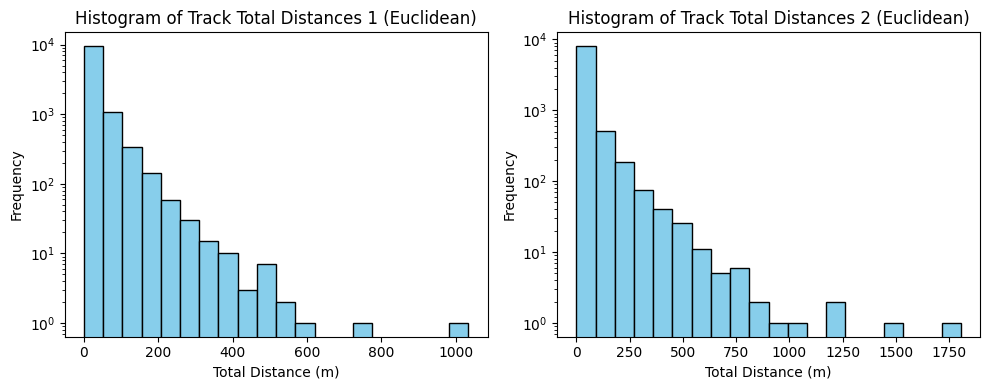

In [293]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

def compute_track_distance(df):
    """
    Computes the total distance of each track using Euclidean distance in a more efficient manner.
    
    Parameters:
    - df: A pandas DataFrame with 'track_id', 'position_x', and 'position_y' columns.
    
    Returns:
    - A pandas DataFrame with 'track_id' and 'total_distance' for each track.
    """
    # Calculate shifted positions for x and y
    df['shifted_x'] = df.groupby('track_id')['position_x'].shift(-1)
    df['shifted_y'] = df.groupby('track_id')['position_y'].shift(-1)
    
    # Vectorized calculation of the Euclidean distance between consecutive points within each track
    df['distance'] = np.sqrt((df['shifted_x'] - df['position_x'])**2 + (df['shifted_y'] - df['position_y'])**2)
    
    # Drop the last row of each track where the shift results in NaN values
    df.dropna(subset=['shifted_x', 'shifted_y'], inplace=True)
    
    # Sum the distances for each track to get the total distance
    total_distance_df = df.groupby('track_id')['distance'].sum().reset_index(name='total_distance')
    
    return total_distance_df

def plot_track_distance_histogram(distance_list):
    """
    Plots histograms of the total distance of each track for multiple datasets, using Euclidean distance.
    
    Parameters:
    - distance_list: A list of pandas DataFrames with 'track_id' and 'total_distance' columns.
    
    Returns:
    - axs: A list of matplotlib axis objects containing the histograms.
    """
    # Determine the grid size
    n = len(distance_list)
    nrows = int(n**0.5) + (1 if n % int(n**0.5) > 0 else 0)  # Add an extra row if there are more items than a perfect square
    ncols = n if nrows == 1 else int(n / nrows) + (n % nrows > 0)
    
    # Create a figure and axes for the grid of histograms
    fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), squeeze=False)
    
    # Flatten the axs array for easy iteration if there's more than one row or column
    axs = axs.flatten()
    
    # Plot each histogram
    for i, distance_df in enumerate(distance_list):
        axs[i].hist(distance_df['total_distance'], bins=20, color='skyblue', edgecolor='black', log=True)
        axs[i].set_title(f'Histogram of Track Total Distances {i+1} (Euclidean)')
        axs[i].set_xlabel('Total Distance (m)')
        axs[i].set_ylabel('Frequency')
    
    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Return the list of axis objects for further manipulation or saving
    return axs

test_linked_distance = compute_track_distance(test_linked)
test_unlinked_distance = compute_track_distance(test_unlinked)
ax = plot_track_distance_histogram([test_unlinked_distance, test_linked_distance])
plt.show()

## Number of made links

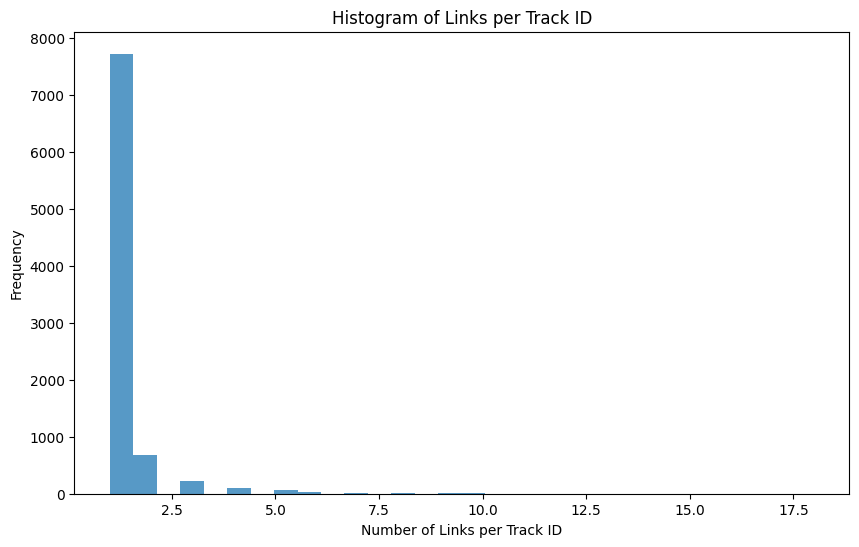

In [313]:
# compute number of made links
test_links = test_linked.groupby('track_id')['raw_track_id'].nunique().reset_index(name='links')

# Plotting the histogram
plt.figure(figsize=(10, 6))
links_per_track.hist(bins=30, alpha=0.75)
plt.title('Histogram of Links per Track ID')
plt.xlabel('Number of Links per Track ID')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

## Track IDs over time

/var/folders/0r/py7njh1j56s1qg51ggxjztz00000gp/T/ipykernel_49611/1052601455.py:29: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  track_counts_per_second = df_copy['track_id'].resample('S').nunique()
/var/folders/0r/py7njh1j56s1qg51ggxjztz00000gp/T/ipykernel_49611/1052601455.py:29: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  track_counts_per_second = df_copy['track_id'].resample('S').nunique()
/var/folders/0r/py7njh1j56s1qg51ggxjztz00000gp/T/ipykernel_49611/1052601455.py:43: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  track_counts_per_second = df_copy['track_id'].resample('S').nunique()
/var/folders/0r/py7njh1j56s1qg51ggxjztz00000gp/T/ipykernel_49611/1052601455.py:43: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  track_counts_per_second = df_copy['track_id'].resample('S'

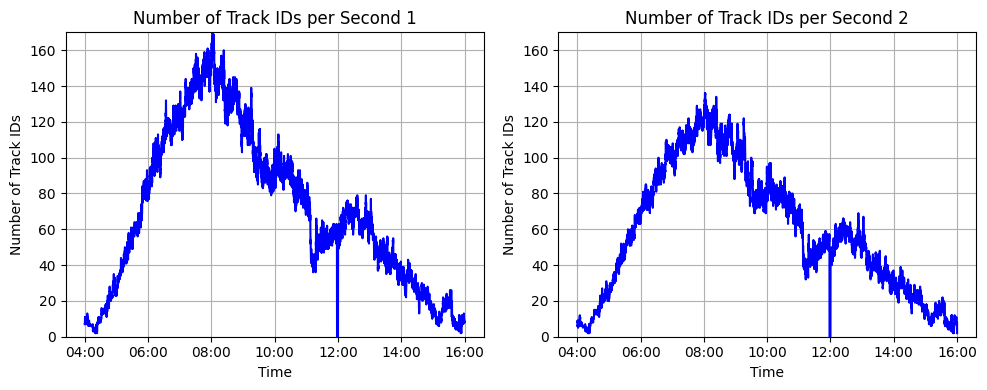

In [300]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import DateFormatter

def plot_tracks_time(df_list):
    """
    Counts the number of unique track IDs per second for multiple datasets and plots this on line graphs.
    
    Parameters:
    - df_list: A list of pandas DataFrames with columns 'time' (as datetime), 'track_id', 'position_x', and 'position_y'.
    """
    # Determine the grid size
    n = len(df_list)
    nrows = int(n**0.5) + (1 if n % int(n**0.5) > 0 else 0)
    ncols = n if nrows == 1 else int(n / nrows) + (n % nrows > 0)
    
    # Create a figure for the grid of line graphs
    fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), squeeze=False)
    
    # Flatten the axs array for easy iteration if there's more than one row or column
    axs = axs.flatten()
    
    # Find the maximum count of unique track IDs per second across all DataFrames
    max_count = 0
    for df in df_list:
        df_copy = df.copy()
        df_copy['time'] = pd.to_datetime(df_copy['time'], unit='ms', origin='unix', utc=True)
        df_copy.set_index('time', inplace=True)
        track_counts_per_second = df_copy['track_id'].resample('S').nunique()
        max_count = max(max_count, track_counts_per_second.max())
    
    for i, df in enumerate(df_list):
        # Work on a copy of the DataFrame to avoid modifying the original
        df_copy = df.copy()
        
        # Ensure 'time' is in datetime format
        df_copy['time'] = pd.to_datetime(df_copy['time'], unit='ms', origin='unix', utc=True)
        
        # Set 'time' as the index
        df_copy.set_index('time', inplace=True)
        
        # Resample to 1-second intervals, counting unique track IDs in each interval
        track_counts_per_second = df_copy['track_id'].resample('S').nunique()
        
        # Plotting
        axs[i].plot(track_counts_per_second.index, track_counts_per_second, color='blue')
        axs[i].set_title(f'Number of Track IDs per Second {i+1}')
        axs[i].set_xlabel('Time')
        axs[i].set_ylabel('Number of Track IDs')
        axs[i].grid(True)
        axs[i].xaxis.set_major_formatter(DateFormatter('%H:%M'))
        
        # Set uniform y-axis limits
        axs[i].set_ylim(0, max_count)
    
    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    plt.show()
    
plot_tracks_time([test_unlinked, test_linked])

## Number of tracks per unit space

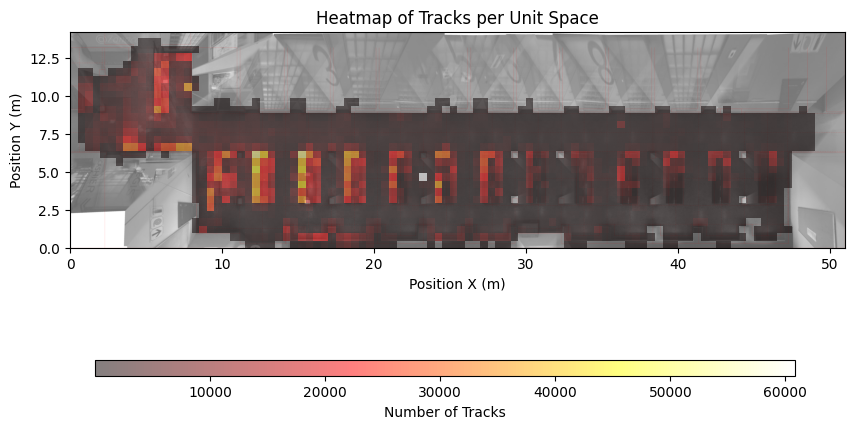

In [301]:
def plot_tracks_spatial(df, square_length=0.5):
    """
    Counts the number of unique tracks per unit space and plots a heatmap over a background image set by the plot_with_background function.
    
    Parameters:
    - df: A pandas DataFrame with columns 'track_id', 'position_x', and 'position_y'.
    - square_length: The length of the side of each square unit (in meters).
    """
    # Define the extent of the space
    x_min, x_max, y_min, y_max = 0, 51, -0.02, 14.214
    
    # Calculate the number of bins along each axis
    x_bins = int(np.ceil((x_max - x_min) / square_length))
    y_bins = int(np.ceil((y_max - y_min) / square_length))
    
    # Create a 2D histogram of track counts per unit space
    heatmap, _, _ = np.histogram2d(df['position_x'], df['position_y'], bins=[x_bins, y_bins], range=[[x_min, x_max], [y_min, y_max]])
    
    # Mask the 0 values
    masked_heatmap = np.ma.masked_where(heatmap == 0, heatmap)

    # Create a plot
    fig, ax = plt.subplots(figsize=(10,8))
    
    # Call plot_with_background to set the background image
    plot_with_background(ax, 1)
    
    # Overlay the heatmap
    im = ax.imshow(masked_heatmap.T, extent=[x_min, x_max, y_min, y_max], origin='lower', cmap='hot', alpha=0.5)

    # Manually specify the position and size of the colorbar
    cbar_ax = fig.add_axes([0.15, 0.2, 0.7, 0.02])  # Adjust these values as needed
    
    # Add a colorbar to the heatmap
    fig.colorbar(im, cax=cbar_ax, ax=ax, label='Number of Tracks', orientation='horizontal')
    
    ax.set_xlabel('Position X (m)')
    ax.set_ylabel('Position Y (m)')
    ax.set_title('Heatmap of Tracks per Unit Space')
    
    plt.show()


plot_tracks_spatial(test_linked)

## Spatial distribution of tracking starts and ends

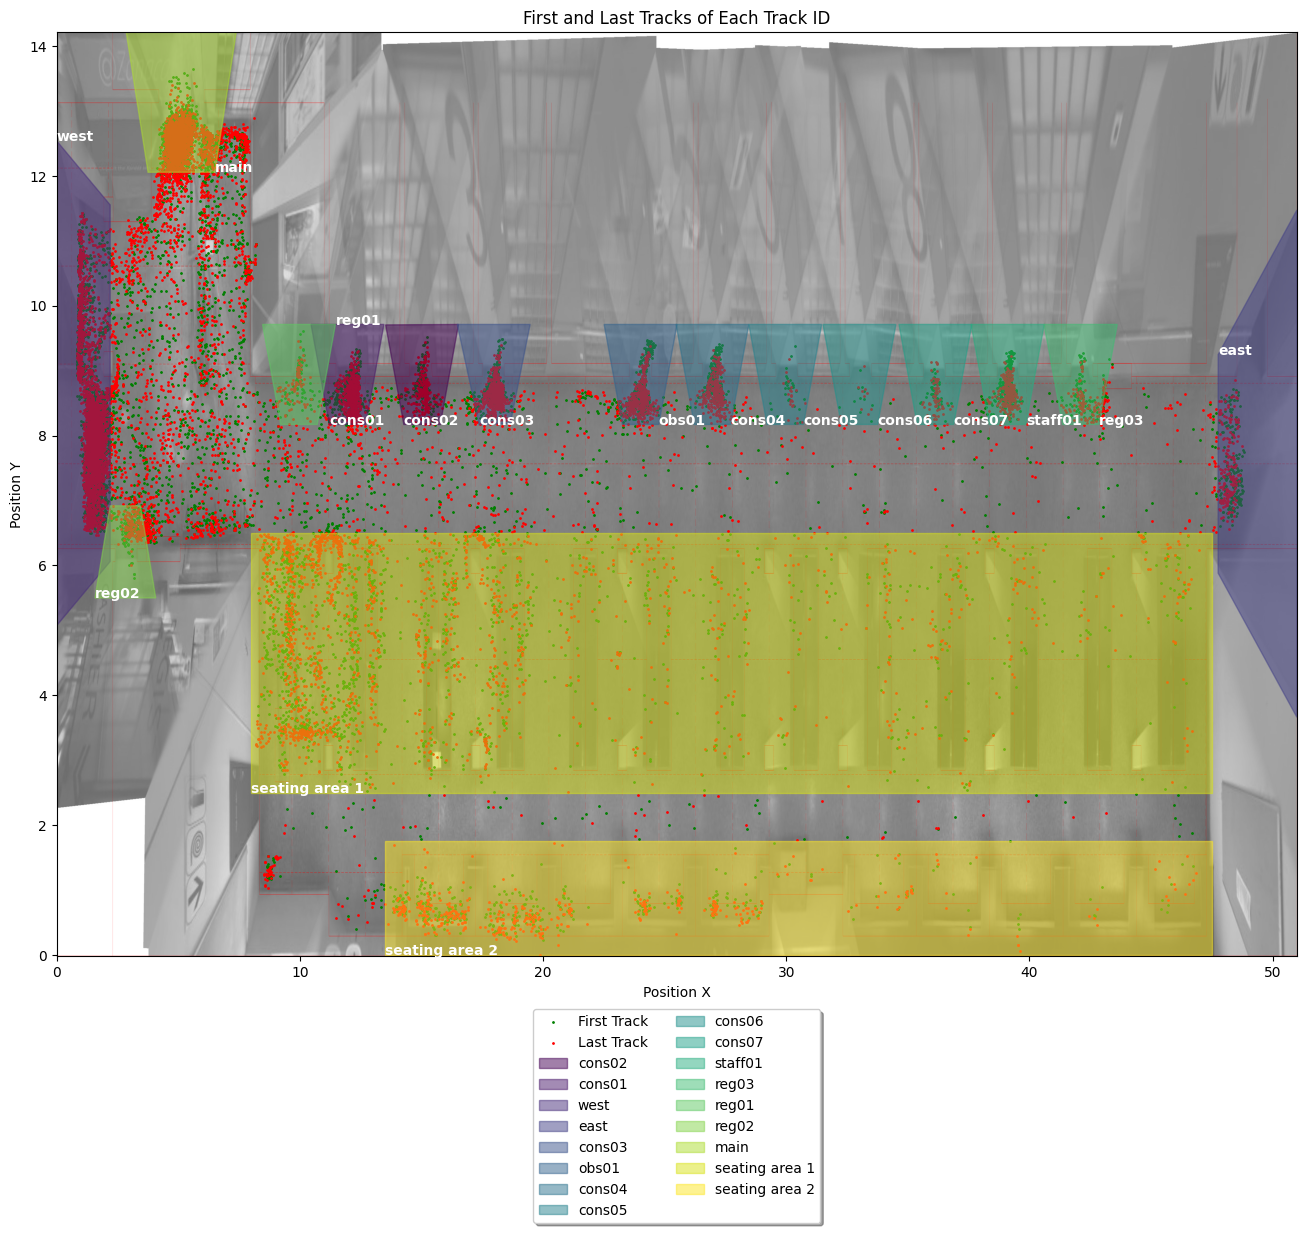

In [302]:
# Create a plot with the background image
def plot_first_last_tracks(df):
	"""
	Plots the first and last track of each track_id in a scatter plot.
	
	Parameters:
	- df: A pandas DataFrame with at least 'track_id', 'position_x', and 'position_y' columns.
	
	Returns:
	- ax: A matplotlib axis object containing the scatter plot.
	"""
	# Ensure the DataFrame is sorted by track_id and then by the tracking time or equivalent
	df_sorted = df.sort_values(by=['track_id', 'time'])
	
	# Group by track_id and get the first and last entry for each track_id
	first_tracks = df_sorted.groupby('track_id').first().reset_index()
	last_tracks = df_sorted.groupby('track_id').last().reset_index()
	
	# Create a scatter plot
	fig, ax = plt.subplots(figsize=(16, 12))
	
	# Plot the first track points in green
	ax.scatter(first_tracks['position_x'], first_tracks['position_y'], color='green', label='First Track', s = 1)
	
	# Plot the last track points in red
	ax.scatter(last_tracks['position_x'], last_tracks['position_y'], color='red', label='Last Track', s = 1)
	
	# Adding legend to distinguish first and last tracks
	ax.legend()
	
	# Labeling the axes
	ax.set_xlabel('Position X')
	ax.set_ylabel('Position Y')
	ax.set_title('First and Last Tracks of Each Track ID')
	
	# Return the axis object for further manipulation or saving
	return ax


ax = plot_first_last_tracks(test_unlinked)
ax = plot_with_background_geom(ax, geometries)
plt.show()

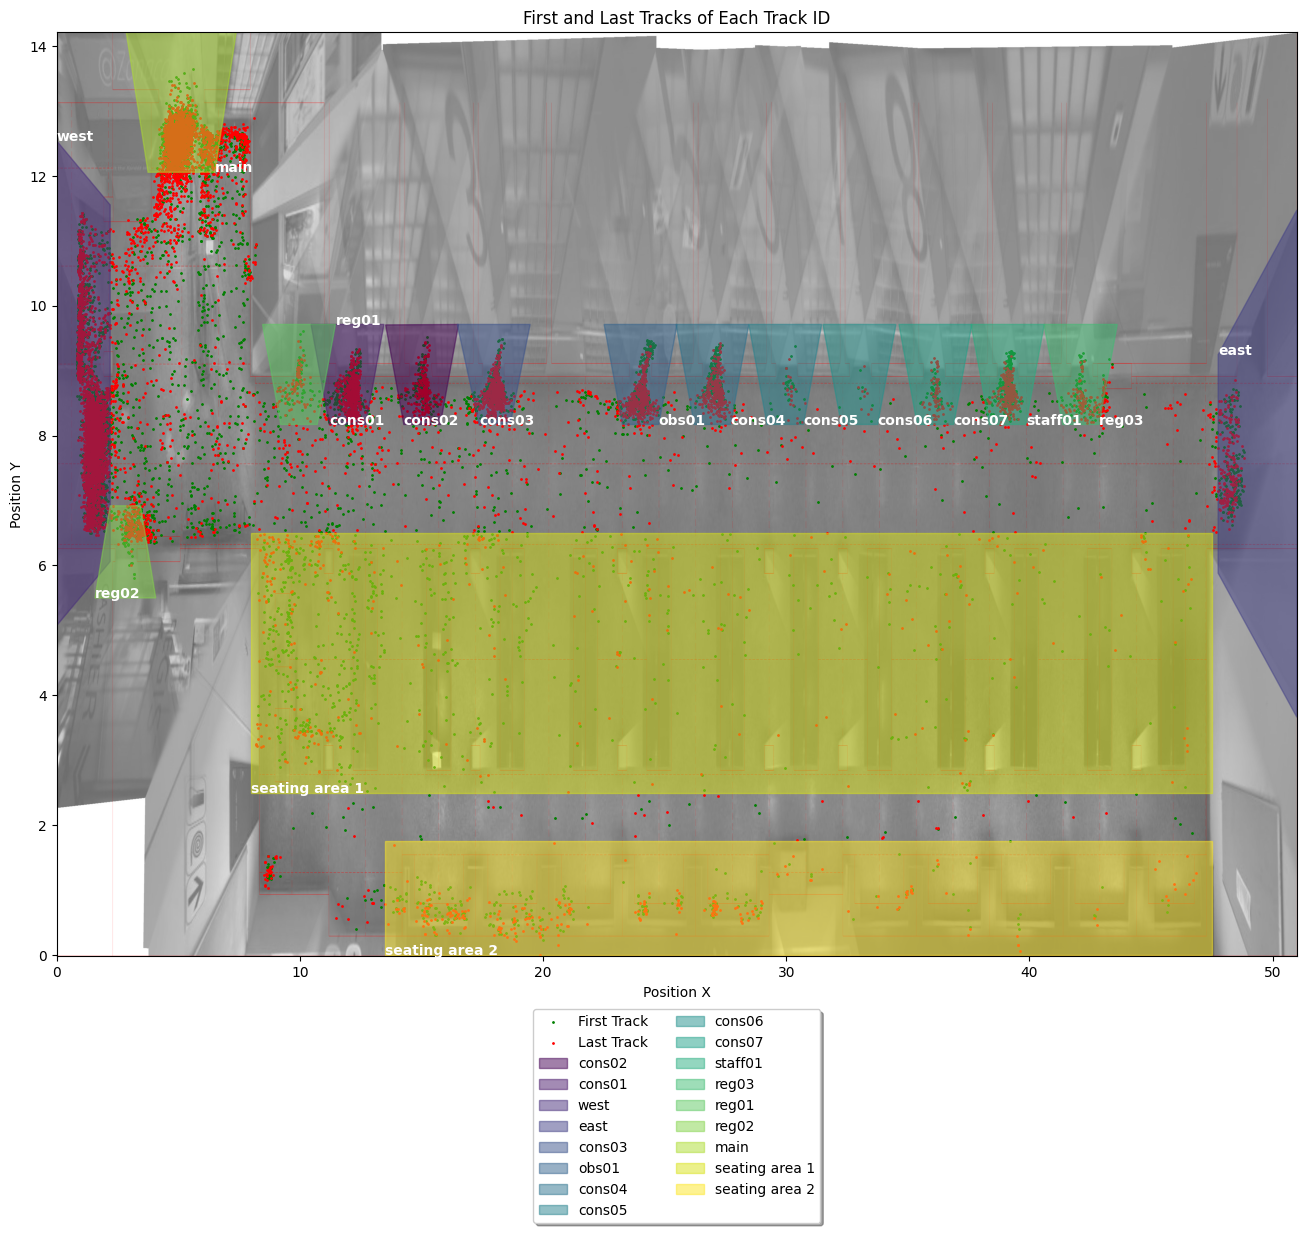

In [303]:
ax = plot_first_last_tracks(test_linked)
ax = plot_with_background_geom(ax, geometries)
plt.show()

## Data quality

In [305]:
def compute_track_proportions(dfs: list) -> pd.DataFrame:
    """
    Computes the track proportions for given datasets, categorizing each track based on its 'near_entry' status at the start and end.
    
    Parameters:
    - dfs: A list of pandas DataFrames, where the first DataFrame is the unlinked dataset and the second (optional) is the linked dataset.
    
    Returns:
    - A pandas DataFrame with the number of tracks per category for each dataset and the difference between them.
    """
    def categorize_track(group):
        """Categorizes each track based on 'near_entry' status."""
        first = group.iloc[0]['near_entry']
        last = group.iloc[-1]['near_entry']
        if not first and last:
            return "Lost start"
        elif first and not last:
            return "Lost end"
        elif not first and not last:
            return "Lost both"
        else:
            return "Complete"
    
    def process_dataset(df):
        """Processes each dataset to compute track proportions."""
        categories = df.groupby('track_id').apply(categorize_track).reset_index(name='Category')
        category_counts = categories['Category'].value_counts().reset_index()
        category_counts.columns = ['Label', 'Number of Tracks']
        total_tracks = len(categories)
        category_counts['Proportion (%)'] = (category_counts['Number of Tracks'] / total_tracks) * 100
        return category_counts.set_index('Label')
    
    # Process the first dataset (unlinked)
    unlinked_counts = process_dataset(dfs[0])
    
    results = unlinked_counts.copy()
    results.columns = ['Number of Tracks (Unlinked)', 'Proportion (%) (Unlinked)']
    
    # If a second dataset (linked) is provided, process it and compute differences
    if len(dfs) > 1:
        linked_counts = process_dataset(dfs[1])
        linked_counts.columns = ['Number of Tracks (Linked)', 'Proportion (%) (Linked)']
        
        # Merge the results
        results = results.join(linked_counts, how='outer').fillna(0)
        
        # Compute differences
        results['Difference in Number'] = results['Number of Tracks (Linked)'] - results['Number of Tracks (Unlinked)']
        results['Difference in Proportion (%)'] = results['Proportion (%) (Linked)'] - results['Proportion (%) (Unlinked)']
        
        # Format the columns to show numbers and proportions in a single column
        results['Unlinked'] = results['Number of Tracks (Unlinked)'].round(0).astype(int).astype(str) + " (" + results['Proportion (%) (Unlinked)'].round(0).astype(int).astype(str) + "%)"
        results['Linked'] = results['Number of Tracks (Linked)'].round(0).astype(int).astype(str) + " (" + results['Proportion (%) (Linked)'].round(0).astype(int).astype(str) + "%)"
        results['Difference'] = results['Difference in Number'].round(0).astype(int).astype(str) + " (" + results['Difference in Proportion (%)'].round(0).astype(int).astype(str) + "%)"
        
        # Select and rename the final columns
        final_columns = ['Unlinked', 'Linked', 'Difference']
    else:
        # Format the column for a single dataset
        results['Unlinked'] = results['Number of Tracks (Unlinked)'].round(0).astype(int).astype(str) + " (" + results['Proportion (%) (Unlinked)'].round(0).astype(int).astype(str) + "%)"
        final_columns = ['Unlinked']
    
    return results[final_columns].reset_index()

result = compute_track_proportions([test_unlinked, test_linked])
print(result)

/var/folders/0r/py7njh1j56s1qg51ggxjztz00000gp/T/ipykernel_49611/2605317735.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  categories = df.groupby('track_id').apply(categorize_track).reset_index(name='Category')


        Label    Unlinked      Linked   Difference
0    Complete  6109 (55%)  5826 (66%)   -283 (11%)
1   Lost both  2171 (19%)   938 (11%)  -1233 (-9%)
2    Lost end  1616 (14%)   964 (11%)   -652 (-4%)
3  Lost start  1309 (12%)  1159 (13%)    -150 (1%)


/var/folders/0r/py7njh1j56s1qg51ggxjztz00000gp/T/ipykernel_49611/2605317735.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  categories = df.groupby('track_id').apply(categorize_track).reset_index(name='Category')


## Bad tracks

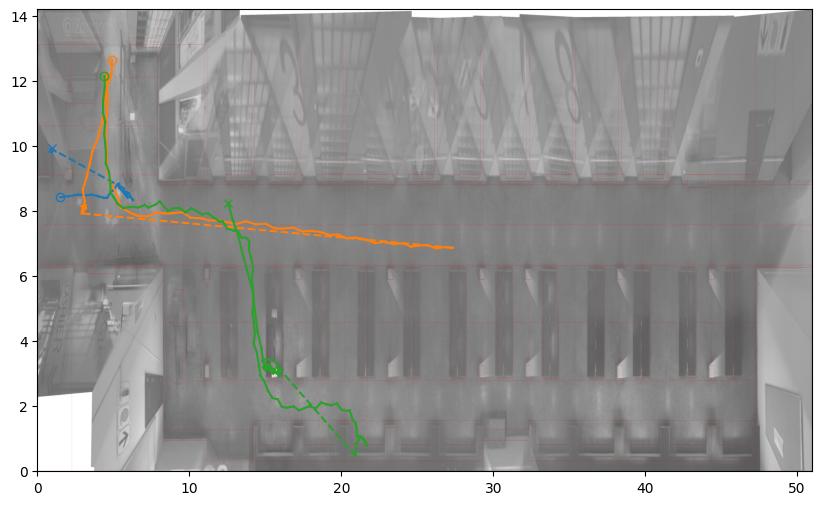

   Threshold  Count   Percent
0          3      6  0.053548
1          5      2  0.017849
2          7      1  0.008925
3         10      1  0.008925


In [290]:
def compute_dxy(df: pd.DataFrame) -> pd.DataFrame:
	"""
	Computes the Euclidean distance between consecutive points within each track_id
	and adds it as a new column 'dxy' to the DataFrame.
	
	Parameters:
	- df (pd.DataFrame): The input DataFrame with columns 'time', 'track_id', 'position_x', and 'position_y'.
	
	Returns:
	- pd.DataFrame: The DataFrame with an additional column 'dxy'.
	"""
	# Group by 'track_id' and calculate the differences within each group
	df['delta_x'] = df.groupby('track_id')['position_x'].diff()
	df['delta_y'] = df.groupby('track_id')['position_y'].diff()
	
	# Compute the Euclidean distance (dxy) using the differences
	df['dxy'] = np.sqrt(df['delta_x']**2 + df['delta_y']**2)
	
	return df

test_unlinked = compute_dxy(test_unlinked)

def plot_bad_tracks(df, min_dxy=4):
    # Filter track_ids with any dxy greater than min_dxy
    track_ids = df[df['dxy'] > min_dxy]['track_id'].unique()
    
    # Randomly sample up to 5 of these track_ids
    sampled_track_ids = np.random.choice(track_ids, size=min(5, len(track_ids)), replace=False)
    
    # Setup plot with background
    fig, ax = plt.subplots(figsize=(10, 6))
    ax = plot_with_background(ax, 1)
    
    # Color cycle for different tracks
    color_cycle = plt.cm.tab10(np.linspace(0, 1, 10))
    
    # Plot each track
    for idx, track_id in enumerate(sampled_track_ids):
        track_data = df[df['track_id'] == track_id].reset_index(drop=True)
        color = color_cycle[idx % len(color_cycle)]
        
        # Iterate through segments of the track
        for i in range(1, len(track_data)):
            segment = track_data.iloc[i-1:i+1]
            if segment['dxy'].iloc[-1] > min_dxy:
                # Dashed line for segments where dxy > min_dxy
                line_style = '--'
            else:
                # Solid line otherwise
                line_style = '-'
            ax.plot(segment['position_x'], segment['position_y'], line_style, color=color)
        
        # Mark the first and last points specifically
        ax.plot(track_data.iloc[0]['position_x'], track_data.iloc[0]['position_y'], 'o', color=color, markerfacecolor='none')  # Open circle
        ax.plot(track_data.iloc[-1]['position_x'], track_data.iloc[-1]['position_y'], 'x', color=color)  # Cross
    
    plt.show()

plot_bad_tracks(test_unlinked)

def count_bad_tracks(df, thresholds=[3, 5, 7, 10]):
    """
    Counts the number of bad tracks for different dxy thresholds and returns a table with counts and percentages.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame with columns 'track_id' and 'dxy'.
    - thresholds (list): A list of thresholds to classify bad tracks.
    
    Returns:
    - pd.DataFrame: A DataFrame with columns 'Threshold', 'Count', and 'Percent' of bad tracks.
    """
    total_tracks = df['track_id'].nunique()
    results = []

    for threshold in thresholds:
        # Count track_ids with any dxy greater than the current threshold
        count = df[df['dxy'] > threshold]['track_id'].nunique()
        percent = (count / total_tracks) * 100
        results.append({'Threshold': threshold, 'Count': count, 'Percent': percent})

    results_df = pd.DataFrame(results)
    return results_df

# Example usage
bad_tracks_unlinked = count_bad_tracks(test_unlinked)
print(bad_tracks_unlinked)

## Sample tracks

In [330]:
def is_sorted(sequence):
    """
    Checks if a sequence is sorted (either in ascending or descending order).
    
    Parameters:
    - sequence: An iterable sequence (e.g., list, tuple).
    
    Returns:
    - A boolean indicating whether the sequence is sorted.
    """
    # Check for ascending order
    is_ascending = sequence == sorted(sequence)
    # Check for descending order
    is_descending = sequence == sorted(sequence, reverse=True)
    
    # Return True if either is True
    return is_ascending or is_descending

is_sorted(test_linked[test_linked['track_id'] == 403180].raw_track_id.tolist())
is_sorted(test_linked[test_linked['track_id'] == 403180].time.tolist())

False

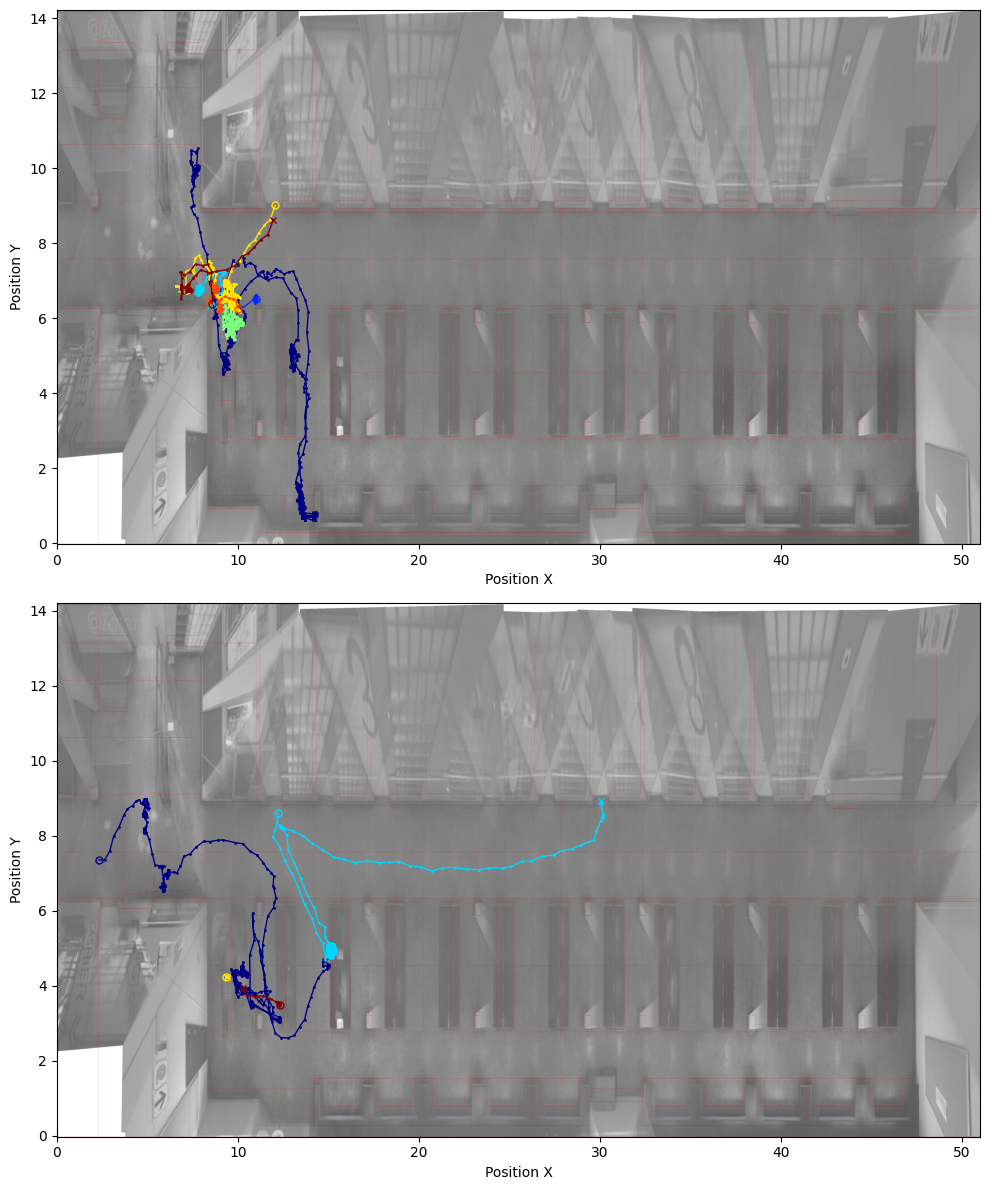

In [320]:
def plot_sample_tracks(df: pd.DataFrame, duration_df: pd.DataFrame, distance_df: pd.DataFrame, link_df: pd.DataFrame, min_time=None, min_distance=None, min_links=1, grid_size=(1, 1)):
    """
    Plots multiple tracks from a dataset, each in a different subplot, filtered by minimum time, distance, and number of links criteria.
    Each line segment (raw_track_id) within a track_id is plotted in a different color. The number of plots corresponds to the grid size.

    Parameters:
    - df (pd.DataFrame): The main dataframe containing track positions and raw_track_id.
    - duration_df (pd.DataFrame): A dataframe containing track durations, indexed by 'track_id'.
    - distance_df (pd.DataFrame): A dataframe containing total distances of tracks, indexed by 'track_id'.
    - link_df (pd.DataFrame): A dataframe containing the number of links (raw_track_id count) per track_id.
    - min_time (Optional[int]): The minimum duration a track must have to be included. Defaults to None.
    - min_distance (Optional[float]): The minimum distance a track must cover to be included. Defaults to None.
    - min_links (int): The minimum number of raw_track_id that have been linked to form a track_id. Defaults to 1.
    - grid_size (tuple): The grid size for plotting multiple tracks. Defaults to (1, 1).
    """
    track_info = pd.merge(duration_df, distance_df, on='track_id')
    track_info = pd.merge(track_info, link_df, on='track_id')
    
    if min_time is not None:
        track_info = track_info[track_info['duration'] >= min_time]
    if min_distance is not None:
        track_info = track_info[track_info['total_distance'] >= min_distance]
    if min_links > 0:
        track_info = track_info[track_info['links'] >= min_links]
    
    if track_info.empty:
        print("No tracks meet the filtering criteria.")
        return
    
    num_plots = grid_size[0] * grid_size[1]
    sampled_track_ids = track_info.sample(n=num_plots)['track_id'].tolist()
    
    fig, axs = plt.subplots(grid_size[0], grid_size[1], figsize=(10 * grid_size[1], 6 * grid_size[0]))
    axs = axs.flatten()  # Flatten in case of a single row/column to simplify iteration
    
    for ax, track_id in zip(axs, sampled_track_ids):
        track_df = df[df['track_id'] == track_id]
        
        if track_df.empty:
            print(f"No data for track_id {track_id}.")
            continue
        
        raw_track_ids = track_df['raw_track_id'].unique()
        colors = plt.cm.jet(np.linspace(0, 1, len(raw_track_ids)))
        
        for i, raw_track_id in enumerate(raw_track_ids):
            segment_df = track_df[track_df['raw_track_id'] == raw_track_id]
            
            ax.plot(segment_df['position_x'], segment_df['position_y'], '-', color=colors[i], linewidth=1)
            
            if len(segment_df) >= 1:
                ax.plot(segment_df.iloc[0]['position_x'], segment_df.iloc[0]['position_y'], 'o', color=colors[i], markerfacecolor='none', markersize=5)
            
            if len(segment_df) > 1:
                ax.plot(segment_df.iloc[-1]['position_x'], segment_df.iloc[-1]['position_y'], 'x', color=colors[i], markersize=5)
            
            if len(segment_df) > 2:
                ax.plot(segment_df.iloc[1:-1]['position_x'], segment_df.iloc[1:-1]['position_y'], 'o', color=colors[i], markersize=1)
        
        ax = plot_with_background(ax, 1)  # Assuming plot_with_background is defined elsewhere
        
        ax.set_xlabel('Position X')
        ax.set_ylabel('Position Y')
    plt.tight_layout()
    plt.show()

plot_sample_tracks(test_linked, test_duration, test_distance, test_links, min_time=5, min_distance=10, min_links=3, grid_size=(2, 1))